# Embedding test

## Utils

In [1]:
! pip install ipywidgets
! pip install plotly
! pip install nbformat>=4.2.0

### Imports

In [2]:
from knnn import KNNN, draw_to_points, draw_to_points 

from sklearn.datasets import make_moons, make_circles, make_swiss_roll, make_blobs
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from functools import cache
import scipy.stats as stats
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import plotly
import plotly.graph_objs as go
from pathlib import Path
# from convert_drawing_to_points import draw_to_points

## Dataset

### Create dataset function

In [3]:
def create_samples(num_of_samples, noises=None, seed = 0, data_types=['moons', 'blobs']):
    # normal data
    t_sample_num = 10_000 # 10_000
    xn_s = []
    xn_test_s = []
    cls_s = []
    cls_test_s = []
    if noises is None:
        noises = [None] * len(data_types)
    for dataset_type, noise in zip(data_types, noises):
        noise = noise if noise is not None else 0.0
        if dataset_type == 'moons':
            all_xn_s, all_cls_s, = make_moons(n_samples=2*t_sample_num, shuffle=True, noise=noise, random_state=seed) 
            all_xn_s *= 10
        elif dataset_type == 'blobs':
            all_xn_s, all_cls_s = make_blobs(n_samples=2*t_sample_num, shuffle=True, centers=3, cluster_std=[0.5, 2., 4])
            all_xn_s, all_cls_s = make_blobs(n_samples=2*t_sample_num, shuffle=True, centers=[[10,0],[0,10],[-10,-10]], cluster_std=[0.5, 2., 4])
            all_xn_s *= 10
        elif dataset_type == 'circles':
            all_xn_s, all_cls_s = make_circles(n_samples=2*t_sample_num, shuffle=True, noise=noise, random_state=seed)
            all_xn_s *= 10
        elif dataset_type == 'swiss_roll':
            all_xn_s, all_cls_s = make_swiss_roll(n_samples=2*t_sample_num, noise=noise, random_state=seed)
            all_xn_s = all_xn_s[:, [0,2]]
            all_xn_s *= 10
        elif dataset_type.startswith('draw'):
            img_name = '_'.join(dataset_type.split('_')[1:]) + '.png'
            imgs_dir_path = Path.cwd() / 'drawings_points' / 'drawings' 
            img_path = imgs_dir_path / img_name
            
            all_xn_s = draw_to_points(img_path=img_path, num_of_points_to_sample=2*t_sample_num)
            all_xn_s = all_xn_s[:, [0,1]]
            all_cls_s = np.zeros(all_xn_s.shape[0])
            all_xn_s *= 10

        else:
            raise ValueError('dataset_type is not supported')
        xn_s += [all_xn_s[:all_xn_s.shape[0]//2, :]]
        xn_test_s += [all_xn_s[all_xn_s.shape[0]//2:, :]]
        cls_s += [all_cls_s[:all_cls_s.shape[0]//2]]
        cls_test_s += [all_cls_s[all_cls_s.shape[0]//2:]]

    xn_s = np.concatenate(xn_s, axis=0)
    xn_test_s = np.concatenate(xn_test_s, axis=0)
    cls_s = np.concatenate(cls_s, axis=0)
    cls_test_s = np.concatenate(cls_test_s, axis=0)
    
    random_choice_ind = np.random.choice(range(len(xn_s)), num_of_samples)
    xn_train_s, cls_train_s = xn_s[random_choice_ind, :], cls_s[random_choice_ind]

    # anomaly data (grid)
    x_min, x_max = xn_train_s[:, 0].min(), xn_train_s[:, 0].max() 
    y_min, y_max = xn_train_s[:, 1].min(), xn_train_s[:, 1].max() 
    len_b = max(x_max - x_min, y_max - y_min)
    mid_x, mid_y = (x_max + x_min) / 2, (y_max + y_min) / 2
    x_max, x_min = mid_x + len_b / 2, mid_x - len_b / 2
    y_max, y_min = mid_y + len_b / 2, mid_y - len_b / 2
    margin = len_b / 4
    x_min, x_max = xn_train_s[:, 0].min() - margin, xn_train_s[:, 0].max() + margin
    y_min, y_max = xn_train_s[:, 1].min() - margin, xn_train_s[:, 1].max() + margin

    step_size_x = (x_max - x_min) / 100
    step_size_y = (y_max - y_min) / 100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size_x), np.arange(y_min, y_max, step_size_y))
    xa_test_s = np.concatenate((np.expand_dims(xx.ravel(), axis=1), np.expand_dims(yy.ravel(), axis=1)), axis=1)
        
    # make test normal the same size as anomaly data
    random_choice_ind_test = np.random.choice(range(xn_test_s.shape[0]), xa_test_s.shape[0])
    xn_test_s, cls_test_s = xn_test_s[random_choice_ind_test, :], cls_test_s[random_choice_ind_test]
    return xn_train_s, xn_test_s, xa_test_s

### Create dataset

In [4]:
num_of_samples = 200
noise = None
xn_s, xn_t_s, xa_s = create_samples(num_of_samples, noises=noise, seed=1, data_types=['moons', 'blobs'])

In [5]:
num_of_samples = 200
noise = None
xn_s, xn_t_s, xa_s = create_samples(num_of_samples, noises=noise, seed=1, data_types=['draw_2hc'])

### Display dataset

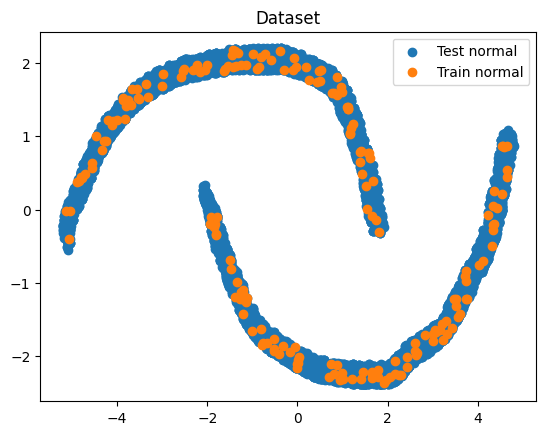

In [6]:
plt.scatter(xn_t_s[:,0], xn_t_s[:,1], label='Test normal')
plt.scatter(xn_s[:,0], xn_s[:,1], label='Train normal')
plt.legend()
plt.title('Dataset')
plt.show()

### Score Function

In [7]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
def score_func(res, gt):
    fpr, tpr, thresholds = metrics.roc_curve(y_true=gt, y_score=res, pos_label=0)
    auroc_res = roc_auc_score(y_score=res, y_true=gt, average=None)

    return {'auroc': auroc_res, 'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}
    

### ROC plot func

In [8]:
def roc_compare_plot(tpr_s, fpr_s, label_s=None):
    if label_s is None:
        label_s = [i for i in range(len(tpr_s))]
    for tpr, fpr, cur_label in zip(tpr_s, fpr_s, label_s) :
        plt.plot(tpr, fpr, label=cur_label)
        
    plt.xlabel('tpr')
    plt.ylabel('fpr')
    # plt.title(f'1: {auroc = :.4f}, 2: {auroc2 = :.4f}')
    plt.legend()
    plt.show()

## Run simple test

#### Run KNNN

In [9]:
knnn_configs_1 = {
    "number_of_neighbors": 5, # flow2, # 3,
    "number_of_neighbors_of_neighbors": 10, # flow7, # 40
    "set_size": 2, # flow2, # 10,
    "distance_function": 'euclidean', # 'euclidean',
}

knnn_configs_2 = knnn_configs_1.copy()
knnn_configs_2['number_of_neighbors'] = 5
knnn_configs_2['number_of_neighbors_of_neighbors'] = 25

knnn = KNNN(**knnn_configs_1)
knnn.fit(xn_s)

knnn2 = KNNN(**knnn_configs_2)
knnn2.fit(xn_s)

Computing eigenvectors and eigenvalues for each set:   0%|          | 0/1 [00:00<?, ?it/s]

Computing eigenvectors and eigenvalues:   0%|          | 0/200 [00:00<?, ?it/s]

Computing eigenvectors and eigenvalues for each set:   0%|          | 0/1 [00:00<?, ?it/s]

Computing eigenvectors and eigenvalues:   0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
res = knnn(xa_s)
res2 = knnn2(xa_s)
res_fin = res
res_fin2 = res2

def combine_normal_and_anomaly_data_for_score_func(normals, anomalies):
    to_test_data_set =  np.concatenate((normals, anomalies), axis=0)
    to_test_gt = np.concatenate([np.zeros(normals.shape[0]), np.ones(anomalies.shape[0])], axis=0)
    return to_test_data_set, to_test_gt

to_test_data_set, to_test_gt = combine_normal_and_anomaly_data_for_score_func(normals=xn_t_s, anomalies=xa_s)

Computing mahalanobis distance for each test sample:   0%|          | 0/10100 [00:00<?, ?it/s]

Computing mahalanobis distance for each test sample:   0%|          | 0/10100 [00:00<?, ?it/s]

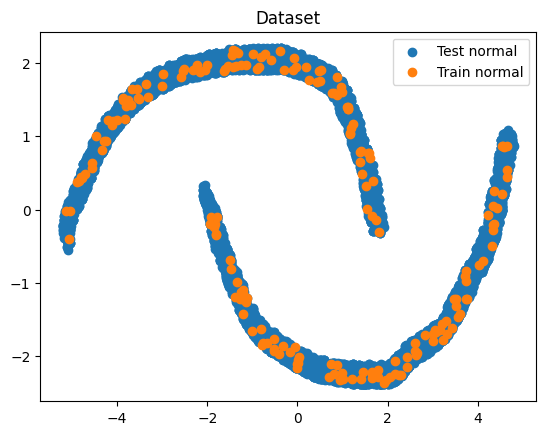

In [11]:
to_train_data_set, to_train_gt = combine_normal_and_anomaly_data_for_score_func(normals=xn_s, anomalies=xa_s)

tmp_dat  = to_test_data_set[to_test_gt == 0]
plt.scatter(tmp_dat[:, 0], tmp_dat[:, 1], label='Test normal')

tmp_dat  = to_train_data_set[to_train_gt == 0]
plt.scatter(tmp_dat[:, 0], tmp_dat[:, 1], label='Train normal')

plt.legend()
plt.title('Dataset')
plt.show()

#### Display results

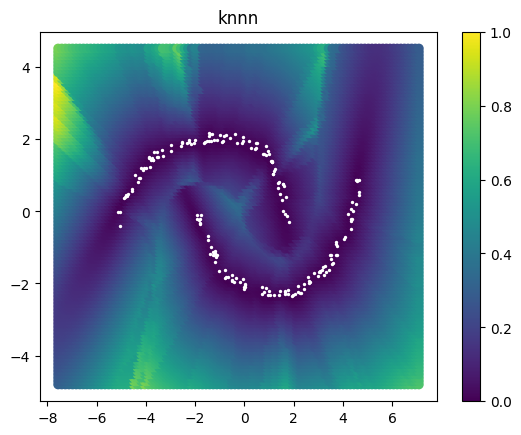

Computing mahalanobis distance for each test sample:   0%|          | 0/20200 [00:00<?, ?it/s]

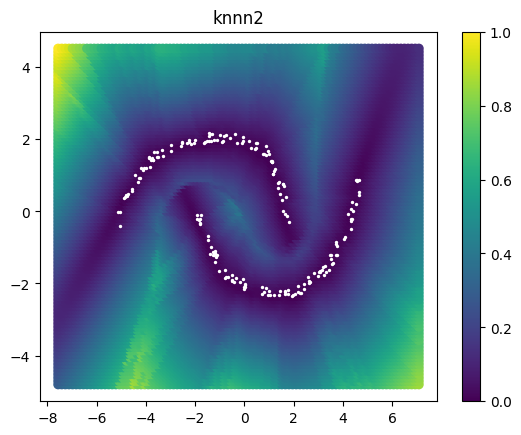

Computing mahalanobis distance for each test sample:   0%|          | 0/20200 [00:00<?, ?it/s]

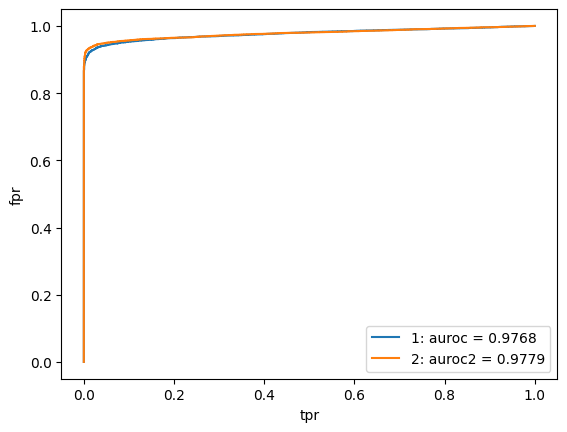

In [12]:
plt.scatter(xa_s[:, 0], xa_s[:, 1], c=res_fin)
plt.scatter(xn_s[:, 0], xn_s[:, 1], s=2, c='w') 
plt.title('knnn')
plt.colorbar()
plt.show()
res_fin_test = knnn(to_test_data_set)
auroc, fpr, tpr, thresholds = score_func(res=res_fin_test, gt=to_test_gt).values()


plt.scatter(xa_s[:, 0], xa_s[:, 1], c=res_fin2)
plt.scatter(xn_s[:, 0], xn_s[:, 1], s=2, c='w')
plt.title('knnn2')
plt.colorbar()
plt.show()
res_fin_test2 = knnn2(to_test_data_set)
auroc2, fpr2, tpr2, thresholds2 = score_func(res=res_fin_test2, gt=to_test_gt).values()


label_1 = f'1: {auroc = :.4f}'
label_2 = f'2: {auroc2 = :.4f}'
roc_compare_plot([tpr, tpr2], [fpr, fpr2], [label_1, label_2])


In [13]:
@interact(dots=fixed(xn_s), neigburs_indexes_train=fixed(knnn.hole_data_indesies), ind=widgets.IntSlider(min=0, max=xn_s.shape[0]-1, step=1, value=0))
def display_neigburs(dots, neigburs_indexes_train, ind):
    plt.scatter(dots[:,0], dots[:,1], s=2, c='g')
    
    neigburs_inds = neigburs_indexes_train[ind]
    neigbur_nodes = dots[neigburs_inds[1:], :]
    plt.scatter(neigbur_nodes[:, 0], neigbur_nodes[:, 1], c='b', s=5)
    
    curr_node = dots[neigburs_inds[0], :]
    plt.scatter(curr_node[0], curr_node[1], c='r', s=5)
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=199), Output()), _dom_classes=('widget-interac…

# Experiments

## Test function

In [14]:
def test_knnn_and_display(samples_norm, samples_norm_test, samples_ano, partial_size=-1, 
                        number_of_neighbors=7, 
                        number_of_neighbors_of_neighbors=15,
                        set_size=2,
                        noise=None,
                        sample_num=0,
                        title=''):
    if sample_num > 0:
        samples_norm = samples_norm[:sample_num, :]
    print(f'{samples_norm.shape[0] = } \n \
          {number_of_neighbors = } \n \
          {number_of_neighbors_of_neighbors = } \n \
          {set_size = } \n \
          ')
    samples_norm = samples_norm.copy()
    
    if noise is not None:
        added_noise = np.random.normal(0, noise, size=(samples_norm.shape))
        samples_norm += added_noise

    knnn = KNNN(number_of_neighbors=number_of_neighbors,
                        number_of_neighbors_of_neighbors=number_of_neighbors_of_neighbors,
                        distance_function='euclidean', set_size=set_size,
                        )
                          
    knnn.fit(samples_norm)    
    res = knnn(samples_ano)
    res_fin = res

    color = 'white' #
    
    # plotly    
    fig = go.Figure()
    anomaly_score_trace = go.Heatmap(
    x=samples_ano[:,0],
    y=samples_ano[:,1],
    z=res_fin,
    zsmooth='best',
    )
    fig.add_trace(anomaly_score_trace)
    norma_samples_trace = go.Scatter(
        x=samples_norm[:,0],
        y=samples_norm[:,1],
        mode='markers',
        marker={'color' :color}
    )
    fig.add_trace(norma_samples_trace)
    fig.update_layout(title=title, height=600, width=600)
    fig.show()

    to_test_data_set, to_test_gt = combine_normal_and_anomaly_data_for_score_func(normals=samples_norm_test, anomalies=samples_ano)
    res = knnn(to_test_data_set)
    auroc_knnn, fpr, tpr, thresholds = score_func(res=res, gt=to_test_gt).values()
    roc_compare_plot([tpr], [fpr], label_s=[f'{auroc_knnn = }'])
    return_dict = {'auroc_knnn': auroc_knnn}
    
    return return_dict

## Interactive Expriment

In [15]:
number_of_neighbors = 1
number_of_neighbors_of_neighbors = 15
noises = [0.01] # 0.01
num_of_samples = 150


xn_train_s, xn_test_s, xa_s = create_samples(num_of_samples=10_000, noises=noises)
xn_s = np.concatenate((xn_train_s, xn_train_s, xn_train_s), 1)
xn_t_s = np.concatenate((xn_test_s, xn_test_s, xn_test_s), 1)
xa_s = np.concatenate((xa_s, xa_s, xa_s), 1)
added_noise = np.random.normal(0, noises, size=(xn_s.shape))
xn_s += added_noise

interact(test_knnn_and_display, samples_norm=fixed(xn_s), samples_norm_test=fixed(xn_t_s), samples_ano=fixed(xa_s), samples_test_norm=fixed(xn_s),
        sample_num=widgets.IntSlider(min=5, max=xn_s.shape[0], step=50, value=num_of_samples, continuous_update=False),
        set_size=widgets.IntSlider(min=1, max=xn_s.shape[1], step=1, value=2, continuous_update=False), 
        number_of_neighbors=widgets.IntSlider(min=1, max=100, step=1, value=number_of_neighbors, continuous_update=False), 
        number_of_neighbors_of_neighbors=widgets.IntSlider(min=3, max=100, step=1, value=number_of_neighbors_of_neighbors, continuous_update=False), 
        noise=widgets.FloatSlider(min=0, max=1, step=0.01, value=noise, continuous_update=False), 
        title=fixed(f'knnn')) 


interactive(children=(IntSlider(value=-1, description='partial_size', max=1, min=-3), IntSlider(value=1, conti…

<function __main__.test_knnn_and_display(samples_norm, samples_norm_test, samples_ano, partial_size=-1, number_of_neighbors=7, number_of_neighbors_of_neighbors=15, set_size=2, noise=None, sample_num=0, title='')>

## Individual Experiments

### Experiment 1 

samples_norm.shape[0] = 150 
           number_of_neighbors = 3 
           number_of_neighbors_of_neighbors = 25 
           set_size = 2 
           


Computing eigenvectors and eigenvalues for each set:   0%|          | 0/1 [00:00<?, ?it/s]

Computing eigenvectors and eigenvalues:   0%|          | 0/150 [00:00<?, ?it/s]

Computing mahalanobis distance for each test sample:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing mahalanobis distance for each test sample:   0%|          | 0/20000 [00:00<?, ?it/s]

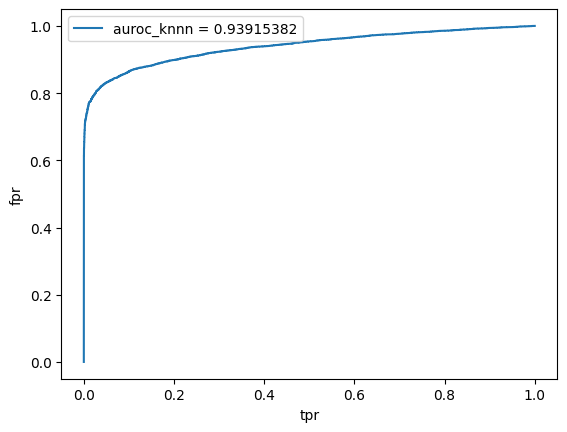

samples_norm.shape[0] = 150 
           number_of_neighbors = 3 
           number_of_neighbors_of_neighbors = 25 
           set_size = 2 
           


Computing eigenvectors and eigenvalues for each set:   0%|          | 0/1 [00:00<?, ?it/s]

Computing eigenvectors and eigenvalues:   0%|          | 0/150 [00:00<?, ?it/s]

Computing mahalanobis distance for each test sample:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing mahalanobis distance for each test sample:   0%|          | 0/20000 [00:00<?, ?it/s]

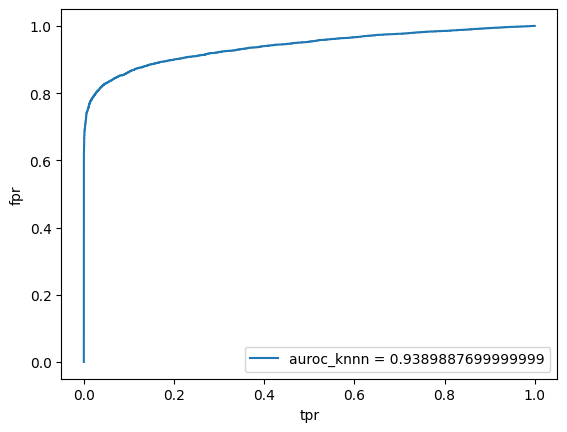

{'auroc_knnn': 0.9389887699999999}

In [16]:
# print('====================================================================')
# print('Experiment 1 : knnn')
# print('====================================================================')

number_of_neighbors = 3
number_of_neighbors_of_neighbors = 25
set_size = 2
num_of_samples = 150
noise=0.05

# xn_s, xn_t_s, xa_s = create_samples(num_of_samples=num_of_samples, noises=[noise], data_types=['blobs'])
xn_s, xn_t_s, xa_s = create_samples(num_of_samples=num_of_samples, noises=[noise], data_types=['moons'])


test_knnn_and_display(samples_norm=xn_s, samples_norm_test=xn_t_s ,samples_ano=xa_s,
                      number_of_neighbors=number_of_neighbors, 
                      number_of_neighbors_of_neighbors=number_of_neighbors_of_neighbors, 
                      set_size=set_size,
                      noise=noise,
                      title=f'knnn - {number_of_neighbors=},  {number_of_neighbors_of_neighbors=}') 
    
test_knnn_and_display(samples_norm=xn_s, samples_norm_test=xn_t_s, samples_ano=xa_s,
                      number_of_neighbors=number_of_neighbors, number_of_neighbors_of_neighbors=number_of_neighbors_of_neighbors, 
                      noise=noise,
                      title=f'knnn - {number_of_neighbors=},  {number_of_neighbors_of_neighbors=}')   
    